## Disclaimer : The Material in the Notebook is Quite Advanced.
# Resources to Get Started
Following some reference material is given to build the background for understanding Variational Inference and Variational Autoencoders.
> 1. [Very well explained Big View Picture of Variational Autoencoders](https://www.youtube.com/watch?v=9zKuYvjFFS8)

> 2. [Proper Course on Basic and Advanced Bayesian Methods in Machine Learning From Top Researchers](https://my.pcloud.com/publink/show?code=kZHRfhkZuXYqMSg482m082mDqjJQBLoIWP2k)

> 3. [Official Course Link](https://www.coursera.org/learn/bayesian-methods-in-machine-learning)

# Variational Autoencoders

Instead of just learning a function representing the data ( a compressed representation) like autoencoders, variational autoencoders learn the parameters of a probability distribution representing the data. Since it learns to model the data, we can sample from the distribution and generate new input data samples. 

So we understand that the main difference comes from the fact that when the hidden layer parameters encode an actual probability distribution, then we can generate samples from this probability distribution.

Variational Autoencoder was introduced in 2014 by Diederik Kingma and Max Welling with intention how autoencoders can be generative.

VAE are generative autoencoders, meaning they can generate new instances that look similar to original dataset used for training.
As mentioned before, VAE learns probability distribution of the data whereas autoencoders learns a function to map each input to a number and decoder learns the reverse mapping.

**Think : Why cannot we generate samples when the hidden layer activations don't correspond to a probability distribution?**

## Why Variational Autoencoder



One reason why we need VI is that numerical integration scales very badly with dimension:
The reason this scales so badly is because of the curse of dimensionality.

The most common place we see Variational Inference is computing posterior distributions in Bayesian models. Recall Bayes' Theorem:

$$P(Z | X)=\frac{P(X, Z)}{\int_{Z} P(X, Z) d Z}$$

Computing the denominator of this fraction is sometimes very, very hard. For example, if Z is multidemensional, and the distributions are not conjugate, there are very limited ways to compute this integral.

Let's make the simplifying assumption that X and Z are independent. This gives us the simplifying assumption:

$$\int_{Z} P(X, Z) d Z=\int_{Z} P(X) P(Z) d Z$$

Obviously if we knew this in practice, we could simply find P(X) by factorising the joint distribution, however the important point here is to show how complex computing this integral is if we don't know an analytical simplification. Let's say $P(Z)$ is a multivariate standard Gaussian.

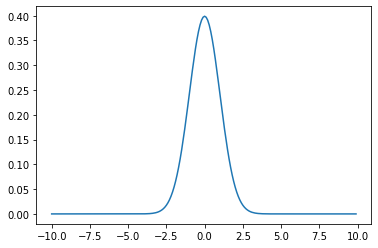

In [21]:
from scipy.stats import multivariate_normal 
x = np.arange(-10, 10, 0.1)
y = multivariate_normal.pdf(x, mean=np.zeros(1), cov=np.ones(1))
plt.plot(x,y)

In 1D this is a simple numeric integral.



In [22]:
import time

x = np.arange(-100, 100, 1)
dx = 1.0
area = 0
start = time.time()
for i in range(len(x)-1):
    h1 = multivariate_normal.pdf(x[i], mean=np.zeros(1), cov=np.ones(1))
    h2 = multivariate_normal.pdf(x[i+1], mean=np.zeros(1), cov=np.ones(1))
    av_h = 0.5*(h1+h2)
    area += av_h * dx
print(area, " - took:", time.time()-start)

1.0000000053505758  - took: 0.06035161018371582


Even in 2D, this starts to become harder



In [23]:
dx = 1.0
area = 0
start = time.time()
for i in range(len(x)-1):
    for j in range(len(x)-1):
        h1 = multivariate_normal.pdf(np.array([x[i], x[j]]), mean=np.zeros(2), cov=np.eye(2))
        h2 = multivariate_normal.pdf(np.array([x[i+1], x[j+1]]), mean=np.zeros(2), cov=np.eye(2))
        h3 = multivariate_normal.pdf(np.array([x[i], x[j+1]]), mean=np.zeros(2), cov=np.eye(2))
        h4 = multivariate_normal.pdf(np.array([x[i+1], x[j]]), mean=np.zeros(2), cov=np.eye(2))
        av_h = 0.25*(h1+h2+h3+h4)
        area += av_h * dx**2
print(area, " - took:", time.time()-start)

1.000000010701151  - took: 20.792203426361084


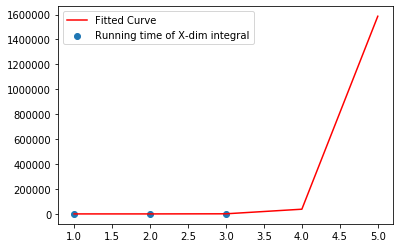

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.array([1,2,3])
x_new = np.linspace(1,5,5)
y = np.array([0.06,21,900])
popt, pcov = curve_fit(func, x, y)
plt.figure()
plt.scatter(x, y, label="Running time of X-dim integral")
plt.plot(x_new, func(x_new, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

So we can see that in 5 dimensions, the integral computation might already take over 1.6 million seconds!?
The reason this scales so badly is because of the curse of dimensionality.


If we use numeric integration to find the n-dimensional volume, then we can approximate this by the average over all the values in n-dimensions multiplied by the grid-distance to the power of n.
As the dimension of the space becomes larger, the discrete volumes we compute with the numerical integral increase exponentially. So in $N-D$, we have to do amount of data points to the power of n evaluations.

If we have an array of 200 numbers, then 
- in 1-D, we have to do ~ 200 evaluations
- in 2d ~ 40,000 
- in 3d ~ 8 million


Let's not forget that this is a simple case too - an independant mulivariate gaussian with known mean and variance. This means, I only have to integrate over a small portion of the real line (-100 to 100 is ample). 

In general, we don't neccesarily know this - in high dimensions with a non analytical joint, we might have to integrate over a very large range to ensure we capture all the mass of Z.
Consider the example where Z is actually a mixture of many gaussians, with means equally spaced between -1e6 and + 1e6, giving us a 3d integral requiring 2e12 evaluations - a near impossible feat, and we are still only in 3D. Move this to 5 dimensions and it becomes 2e30 evaluations!!

**The aim of variational inference is to develop bounds in order to get a tractable approximation.**

In [5]:
import os
from IPython.display import Image
os.listdir("img")

['autoencoder_structure.PNG',
 'variational_autoencoder.png',
 'nn_all_combined_image.jpg']

## Understanding the Background Knowledge for Variational Autoencoder

In the previous post, I talked about different types of bounds we could have, and why we need to use them. As a quick recap, we are looking to compute the marginalization of a joint distribution in a general setting: $P(X)=\int_{Z} P(X, Z) d Z$

### Evidence
Evidence is the denominator  in the Bayes theorem and it is also called the distribution of the data $P(X)$.


### Deriving Variational Lower Bound Using Jensen's Inequality
Previously, I showed how this can be an incredibly difficult thing to compute using standard methods, such as numerical integration, because of the curse of dimensionality.

$$\log P(X)=\log \left[\int_{Z} P(X, Z) d Z\right]$$
$$\log P(X)=\log \left[\int_{Z} P(X, Z) \frac{q(Z)}{q(Z)} d Z\right]=\log E_{q}\left[\frac{P(X, Z)}{q(Z)}\right]$$

Since [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality#Measure-theoretic_and_probabilistic_form) states
$$\log E_{q}\left[\frac{P(X, Z)}{q(Z)}\right] \geq E_{q}\left[\log \frac{P(X, Z)}{q(Z)}\right]$$

then

$$\begin{array}{l}{\log P(X)=\log E_{q}\left[\frac{P(X, Z)}{q(Z)}\right] \geq E_{q}\left[\log \frac{P(X, Z)}{q(Z)}\right]} \\ {\log P(X) \geq E_{q}\left[\log \frac{P(X, Z)}{q(Z)}\right]=\mathcal{L}}\end{array}
$$

#### Variational Lower Bound
$$\mathcal{L}=\int_{Z} q(Z) \log \frac{P(Z, X)}{q(Z)} d Z$$

From this, the role of the ELBO is obvious; it is a lower bound on the "evidence", P(X), so we can use this to get an approximation for the evidence.

### Deriving Variational Lower Bound using K-L Divergence
$$\begin{array}{l}{D_{K L}(q(Z) \| P(Z | X))=-E_{q}\left[\log \frac{P(Z | X)}{q(Z)}\right]=-E_{q}[\log P(Z | X)-\log q(Z)]} \\ {-E_{q}[\log P(Z | X)-\log q(Z)]=-E_{q}\left[\log \frac{P(Z, X)}{P(X)}-\log q(Z)\right]=} \\ {-E_{q}[\log P(Z, X)-\log P(X)-\log q(Z)]}\end{array}$$

Since $\log P(X)$ is independant of $Z$, so it's expectation under $q(Z)$ is itself. 
We can thus split the last step into two terms:

$$\begin{array}{l}{-E_{q}[\log P(Z, X)-\log P(X)-\log q(Z)]=-E_{q}[\log P(Z, X)-\log q(Z)]} \\ {+E_{q}[\log P(X)]}\end{array}$$

Therefore, we arrive at;

$$D_{K L}(q(z) \| P(Z | X))=-E_{q}[\log P(Z, X)-\log q(Z)]+\log P(X)$$


The expectation term is the same as the term we called $\mathcal{L}$ in the previous section, so rewriting;

$$D_{K L}(q(z) \| P(Z | X))=-\mathcal{L}+\log P(X)$$


The original goal was to find an approximation $q(z)$ that is close to the true posterior. So we are varying $q$ in order to minimise the KL-Divergence between it and the posterior. 
The log evidence is independent of $q$, so it doesn't matter how we vary $q$, it is just a constant term. 

So to minimise the LHS, we have to minimise $−\mathcal{L}$, which is equivalent to maximising $\mathcal{L}$.

Looking at the **ELBO** from this perspective, we see that 

**the q that maximises the ELBO also minimises the KL-Divergence between itself and the true posterior**

### Summary of ELBO or Variational Lower Bound
From the above two angles, we can see the roles that the component parts of the ELBO play. The ELBO itself is a lower bound on the evidence, whilst the distribution q serves as the approximation of the true posterior.

### Reparametrization Trick and Why Should Sampling be Differentiable

[Resource](https://chrisorm.github.io/VI-reparam.html)

[Where the idea was popularized](https://arxiv.org/pdf/1312.6114.pdf)

[Typical reparametrization trick is based on this](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family)

Recall the variational lower bound $$\mathcal{L}=\int_{Z} q(Z) \log \frac{P(Z, X)}{q(Z)} d Z$$

Using Monte Carlo sampling, one can estimate that integral using a sum, and the distribution $q(Z)$ by sampling.

The important thing to remember, is that when we take the gradient with respect to the parameters of the ELBO , it is easy to not incorporate the effect of the parameters on the expectation.

#### Example
Consider sampling from a uniform distribution $U \left[a,b\right]$. 
If we change the values of $a$ and $b$, then obviously this will change our samples! If we generate samples from this distribution outside of our simulation program, this gradient information will be lost.

#### Example of Reparametrization Trick Using Inverse CDF
If the pdf we wish to sample from has a tractable inverse CDF (quantile function), we can use this 
to transform a $U[0,1]$ sample to a sample from the target distribution, and the gradient will be properly accounted for.

Rayleigh Distribution CDF  $ C=1-\exp \frac{x^{2}}{2 \sigma^{2}}$

If we can generate values for $C$ from the standard Uniform distribution, then the inverse of this CDF has Rayleigh Distribution.
This was based on the assumption that the distribution has a well-defined CDF.
$$\begin{array}{l}{1-C=\exp \frac{x^{2}}{2 \sigma^{2}}} \\ {\ln (1-C)=\frac{x^{2}}{2 \sigma^{2}}} \\ {\sigma \sqrt{2 \ln (1-C)}=x}\end{array}$$
As a check if we apply the Rayleigh CDF to $x$, this will result in obtaining the $C$, which is the CDF for Rayleigh distribution, so $$x  \sim Rayleigh$$

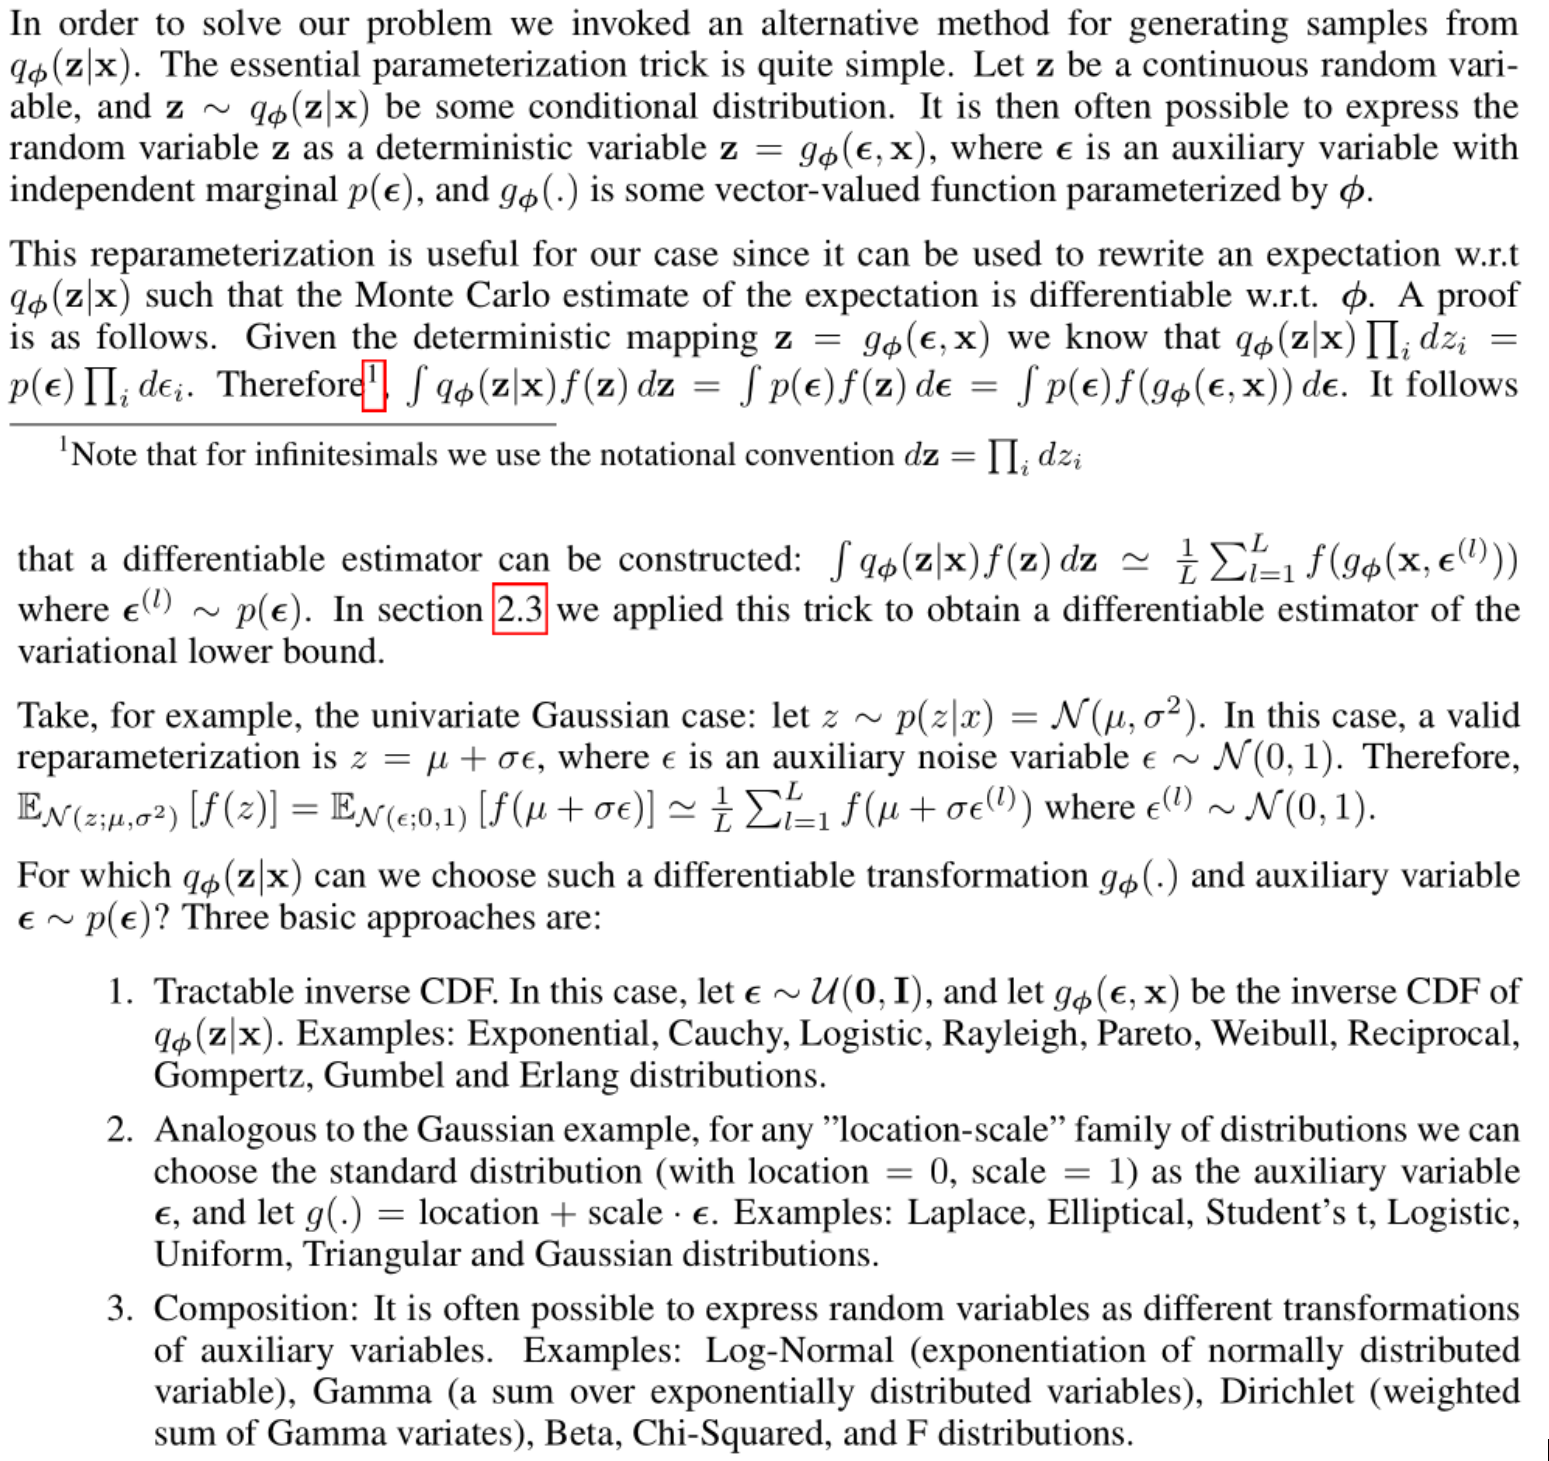

In [54]:
from IPython.display import Image
Image("img/reparametrization.PNG")

# Variational Inference 
## Intrduction
[Resource](https://chrisorm.github.io/VI-to-VAE.html)
In previous posts, we have had a fixed model, and are looking to compute an approximate posterior, often because this is computationally hard to do exactly. To do this, we derived the ELBO, which revolves around the KL-divergence to measure the 'closeness' of the true and approximate posteriors. Let's denote the parameters of our approximate posterior as $\varphi$.
$$\mathcal{L} = E_{q}[log \ \frac{P(X,Z)}{q(Z)}] = E_{q}[log \ P(X,Z) - log \ q_{\phi}(Z)]$$
In order to find our approximation, $q$, we solve: $max_{\phi}(\mathcal{L})$

### Variational Inference : Learning the True Joint 
The natural question to ask is "what if we don't know the model for the joint distribution?". Let's first imagine that we do have a form for the model - e.g. it is normally distributed, but we don't know the parameters of this model. We can use maximum likelihood to learn the parameters of our true model, which we will denote as $\theta$.

So, if we want to learn both the model and the approximate posterior, we can rewrite the above objective as:

$$max_{\phi}max_{\theta} \ E_{p_{D}}[ \mathcal{L}] = max_{\phi, \theta} E_{p_{D}}[E_{q}[log \ P_{\theta}(X,Z) - log \ q_{\phi}(Z)]]$$

where $p_D(X)$ denotes the distribution of the data. In practice, we have some data, $X$, and we minimise the mean of the loss function over this data.

This represents a very minor change to the previous framework, and this is quite natural to handle in modern autodiff framworks.



### From Variational Inference to Variational Autoencoders 
One final step brings us to Variational Autoencoders. The problem with doing simple maximum likelihood as outlined before, is that it is very constraining. If I want to learn a model over Gaussians, it's fine, but if I want to learn a model of the distribution of images that contain zebras, specifying the model is a problem!

To solve this problem, VAEs replace the explicit model with a neural network. Firstly, we make the near trivial extension that the approximate posterior is given by $q(z \mid x)$. The original paper took the posterior as:
$$q(z \mid X) \sim N(\mu_{q \mid X}, \Sigma_{q \mid X})$$

The notation here means that every x value has its own mean and variance associated with it - so if we have n data points, we learn n means and n covariances.

We also specify the joint as a prior on $Z$ and a likelihood term on $x$. The prior is a unit gaussian.

$P(Z) \sim N(0,I)$

The form of $ P(X \mid Z)$ is either a Gaussian or Bernoulli, depending on the data.

### Distributions from Neural Networks

In order to have both the approximate posterior and likelihood terms, we use neural networks to learn the form. In the case of the likelihood, we have a neural network that takes a sample from $P(Z)$ as input, and outputs a mean and a variance of the likelihood distribution if it is Gaussian, or the Bernoulli parameter if not.

The approximate posterior is parameterised by a neural network that takes a sample of our data as input, and outputs a mean and variance for the approximate posterior at this $X$ value.

In short, the neural networks act a bit like lookup tables - we pass in an input value and get the parameters of the distribution out. From there, everything is much the same as before - we maximise the ELBO.

Let's assume that the likelihood is given be a Gaussian:

$$P(X \mid Z) \sim N(f(Z), g(Z))$$

Where $f$ and $g$ are our neural network. Assuming we don't use a trivial network (e.g. no hidden layers or no non-linearities), f and g are likely to be far from linear. This means the joint is no longer a Gaussian, but this is a good thing! If the network is sufficiently flexible, it can learn very complex joints that are not at all similar to a Gaussian.

### Some complications to be aware of
One obvious problem comes from the posterior - whereas before we had to only learn a single posterior, now we learn one for each data point. This means if we have lots of data, this may be a problem!

$$q(z \mid X) \sim N(h(X), k(X))$$

Another, more subtle issue comes from the ELBO itself.

$$\mathcal{L} = E_{q}[log \ \frac{P(X,Z)}{q(Z \mid X)}]$$

We encounter problems if the support of the distributions P and q are different. If there is some point where the distribution under P is non-zero, but the distribution under q is very small, the bound becomes very large. If there is a point where q is actually or numerically zero, the bound is infinite.

As the bound becomes very large, the gradient signal we get becomes smaller and smaller, and so we may well encounter convergence issues. 

## What does a Variational Autoencoder look like?

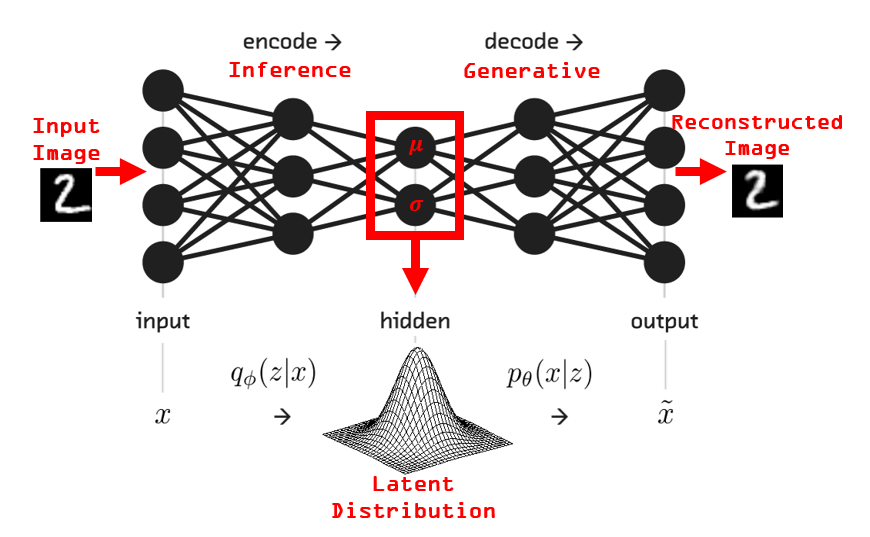

In [6]:
Image(filename="./img/variational_autoencoder.png")

## Build your VAE 


[LINK](https://chrisorm.github.io/VAE-pyt.html)
### Prototype Problem for Understanding Variational Autoencoder
Problem
Rather than resorting to MNIST, we will try to learn the distribution of one-hot 4 dimensional vectors. This is simple enough that we are able to use a latent variable of size 2 ($\mu$ and $\sigma$) - and we can therefore visualise the distribution learnt by the model.

To model this, we will use the following specification:
$$\begin{array}{l}{p(z) \sim \mathcal{N}\left(0, I_{2}\right)} \\ {p(x \mid z) \sim \mathcal{N}(f(z)[0], f(z)[1])} \\ {q(z \mid x) \sim \mathcal{N}(g(x)[0], g(x)[1])}\end{array},$$
where $p(z)$ is the latent representation prior (2-D Gaussian)

$p(z \mid x )$ is the likelihood parametrized by the neural network $f$ 

$q(z \mid x)$ is the posterior distribution of the latent space, given the data $x$, parametrized by neural network $g$

### Intuition to Understand the Model

From the above probabilistic formulation, we can offer an intuition behind the roles of the neural networks. 

- Network $g$ can be seen as an encoder - it takes a sample, and transforms this into the parameters of the posterior over z. 
- Network f is a decoder - it takes the latent "representation", $z$, and turns this into a distribution over $x$.

At test time, we can simply take the mode of the two distributions, and in this case, we get an encoder-decoder pair:

$$\begin{array}{l}{E(x, z)=\operatorname{argmax}_{z} q(z | x)} \\ {D(x, z)=\operatorname{argmax}_{x} p(x | z)}\end{array}$$

In terms of this particular prototype model, this means that 

1. given a basis vector, find the latent space variable value that yields the maximum probability of getting that value
2. given the parameter value from the latent space, find a basis vector that corresponds to this parameter value with the highest probability

In [2]:
import numpy as np

representation_size = 2
input_size = 4
n_samples = 2000
batch_size = 5
n_samples_per_batch = n_samples//input_size

y = np.array([i for i in range(input_size)  for _ in range(n_samples_per_batch)])

d = np.identity(input_size)
x = np.array([d[i] for i in y], dtype=np.float32)

In [3]:
#print(x[[10, 58 ,610, 790, 1123, 1258, 1506, 1988]])

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [24]:
x.shape


(2000, 4)

Let's now write our own custom Variational Autoencoder class.
First, any Pytorch module should inherit the structure from nn.Module same way as in Python every object inherits its structure from object.


### Class Initialization


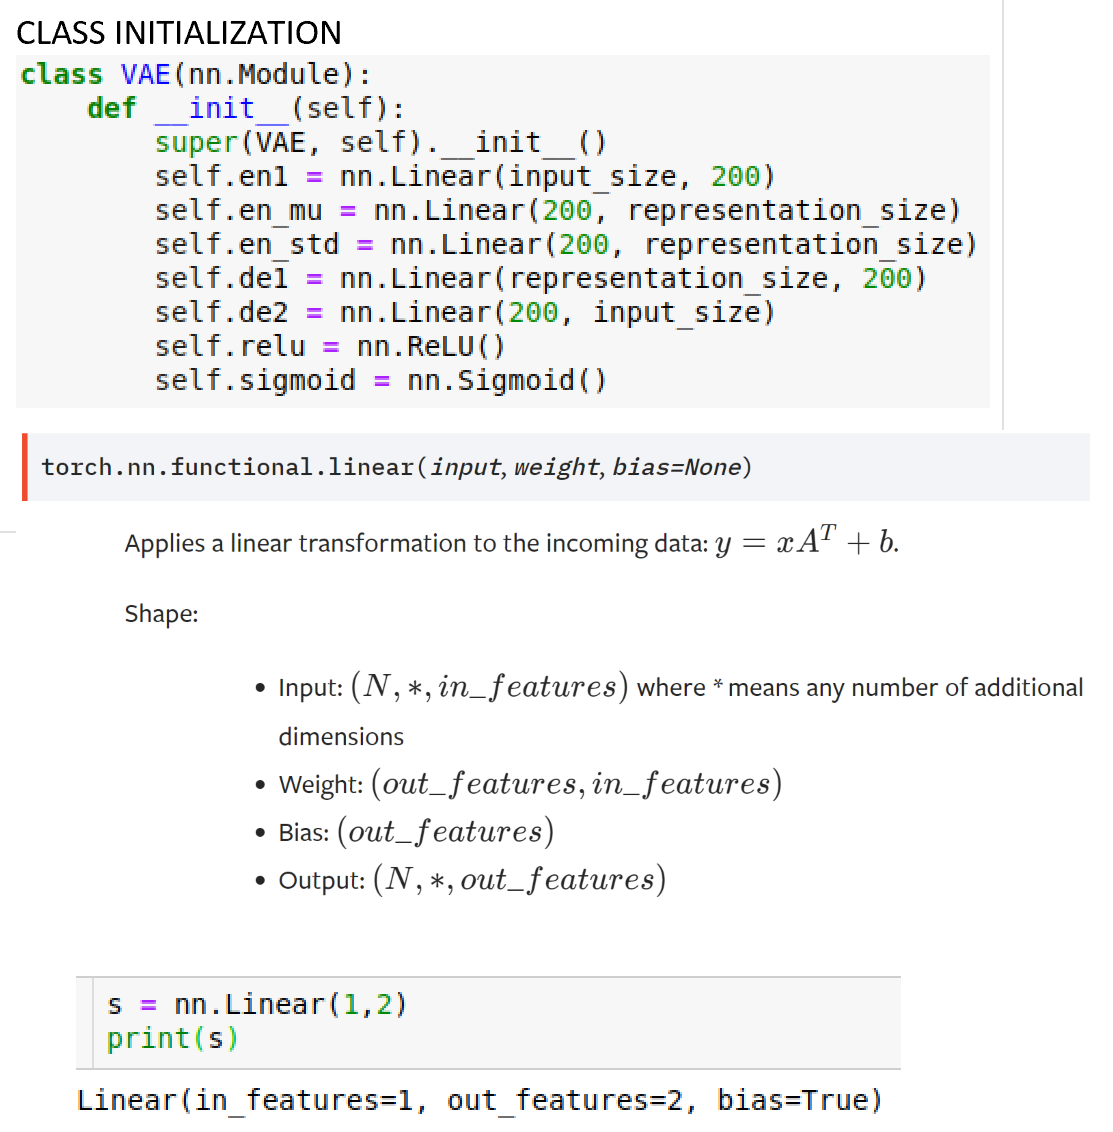

In [2]:
from IPython.display import Image
Image("img/initialization.PNG")

We initialize the VAE class by defining the Encoder that maps an array of 200 numbers to z-layer defined by the mean and sigma, with representation size of 2 (one neuron for mean and the other for sigma). The linear layer defines the weight matrix $A$ that implements this linear transformation.
As an opposite to that, decoder 1 decodes the latent space representation back to the 200-dimensional representation, making use of its own weight matrix.

In initialization, also the ReLu and Sigmoidal Activation functions are defined.

###  Methods defined in the VAE Class

#### Encoder (`encode`)

#### Decoder (`decode`)



#### Forward pass (`forward`)

#### Notice the absence of backward pass (`backward`)

If the sampling has been made differentiable, the backward method can be called on the loss directly!

#### Loss Computation (`loss`)

#### Get Latent Space Sample (`get_z`)

#### Reparametrization trick (`reparam`)


Let's now analyze the idea of the reparametriation trick in our example.
Recall that the posterior distribution of the parameters is the distribution of the parameters after having observed the data. 
In neural network context this means that the neural network has been trained.

We don't know what the (latent) posterior distribution of the one-hot encoded (unit) vectors should be, but we can model them to originate from the standard bivariate Gaussian distribution with unknown mean vector and unknown variance vector but with 0-correlations, since we know that the unit vectors are orthogonal to each other and  in that case, the off-diagonal covariances are 0.

Our goal is to find these true posterior distribution $q$ parameter functions $\vec{\mu}$ and $\vec{\sigma}$ that are parametrized by two parts of our variational autoencoder network.

From the theoretical part we know that the true posterior is approximated by the variational distribution $q_\varphi(z)$, where $\varphi = (\vec{\mu},\vec{\sigma})$ and to find that distribution, the variational (evidence) lower bound $\mathcal{L}$ has to be maximized w.r.t. $\varphi$. 

Recall that the evidence lower bound appears as the denominator in the Bayes' rule for finding the posterior distribution and it gives the lower bound for the probability of the data (evidence).

To maximize the variational lower bound $\mathcal{L}$, the derivatives of the variational distribution w.r.t. to $\varphi$ have to be computed in such a way that is not changed by resampling.

To be able to do that, denote the variatinal (evidence) lower bound by $\mathcal{L}$ and consider the following image:


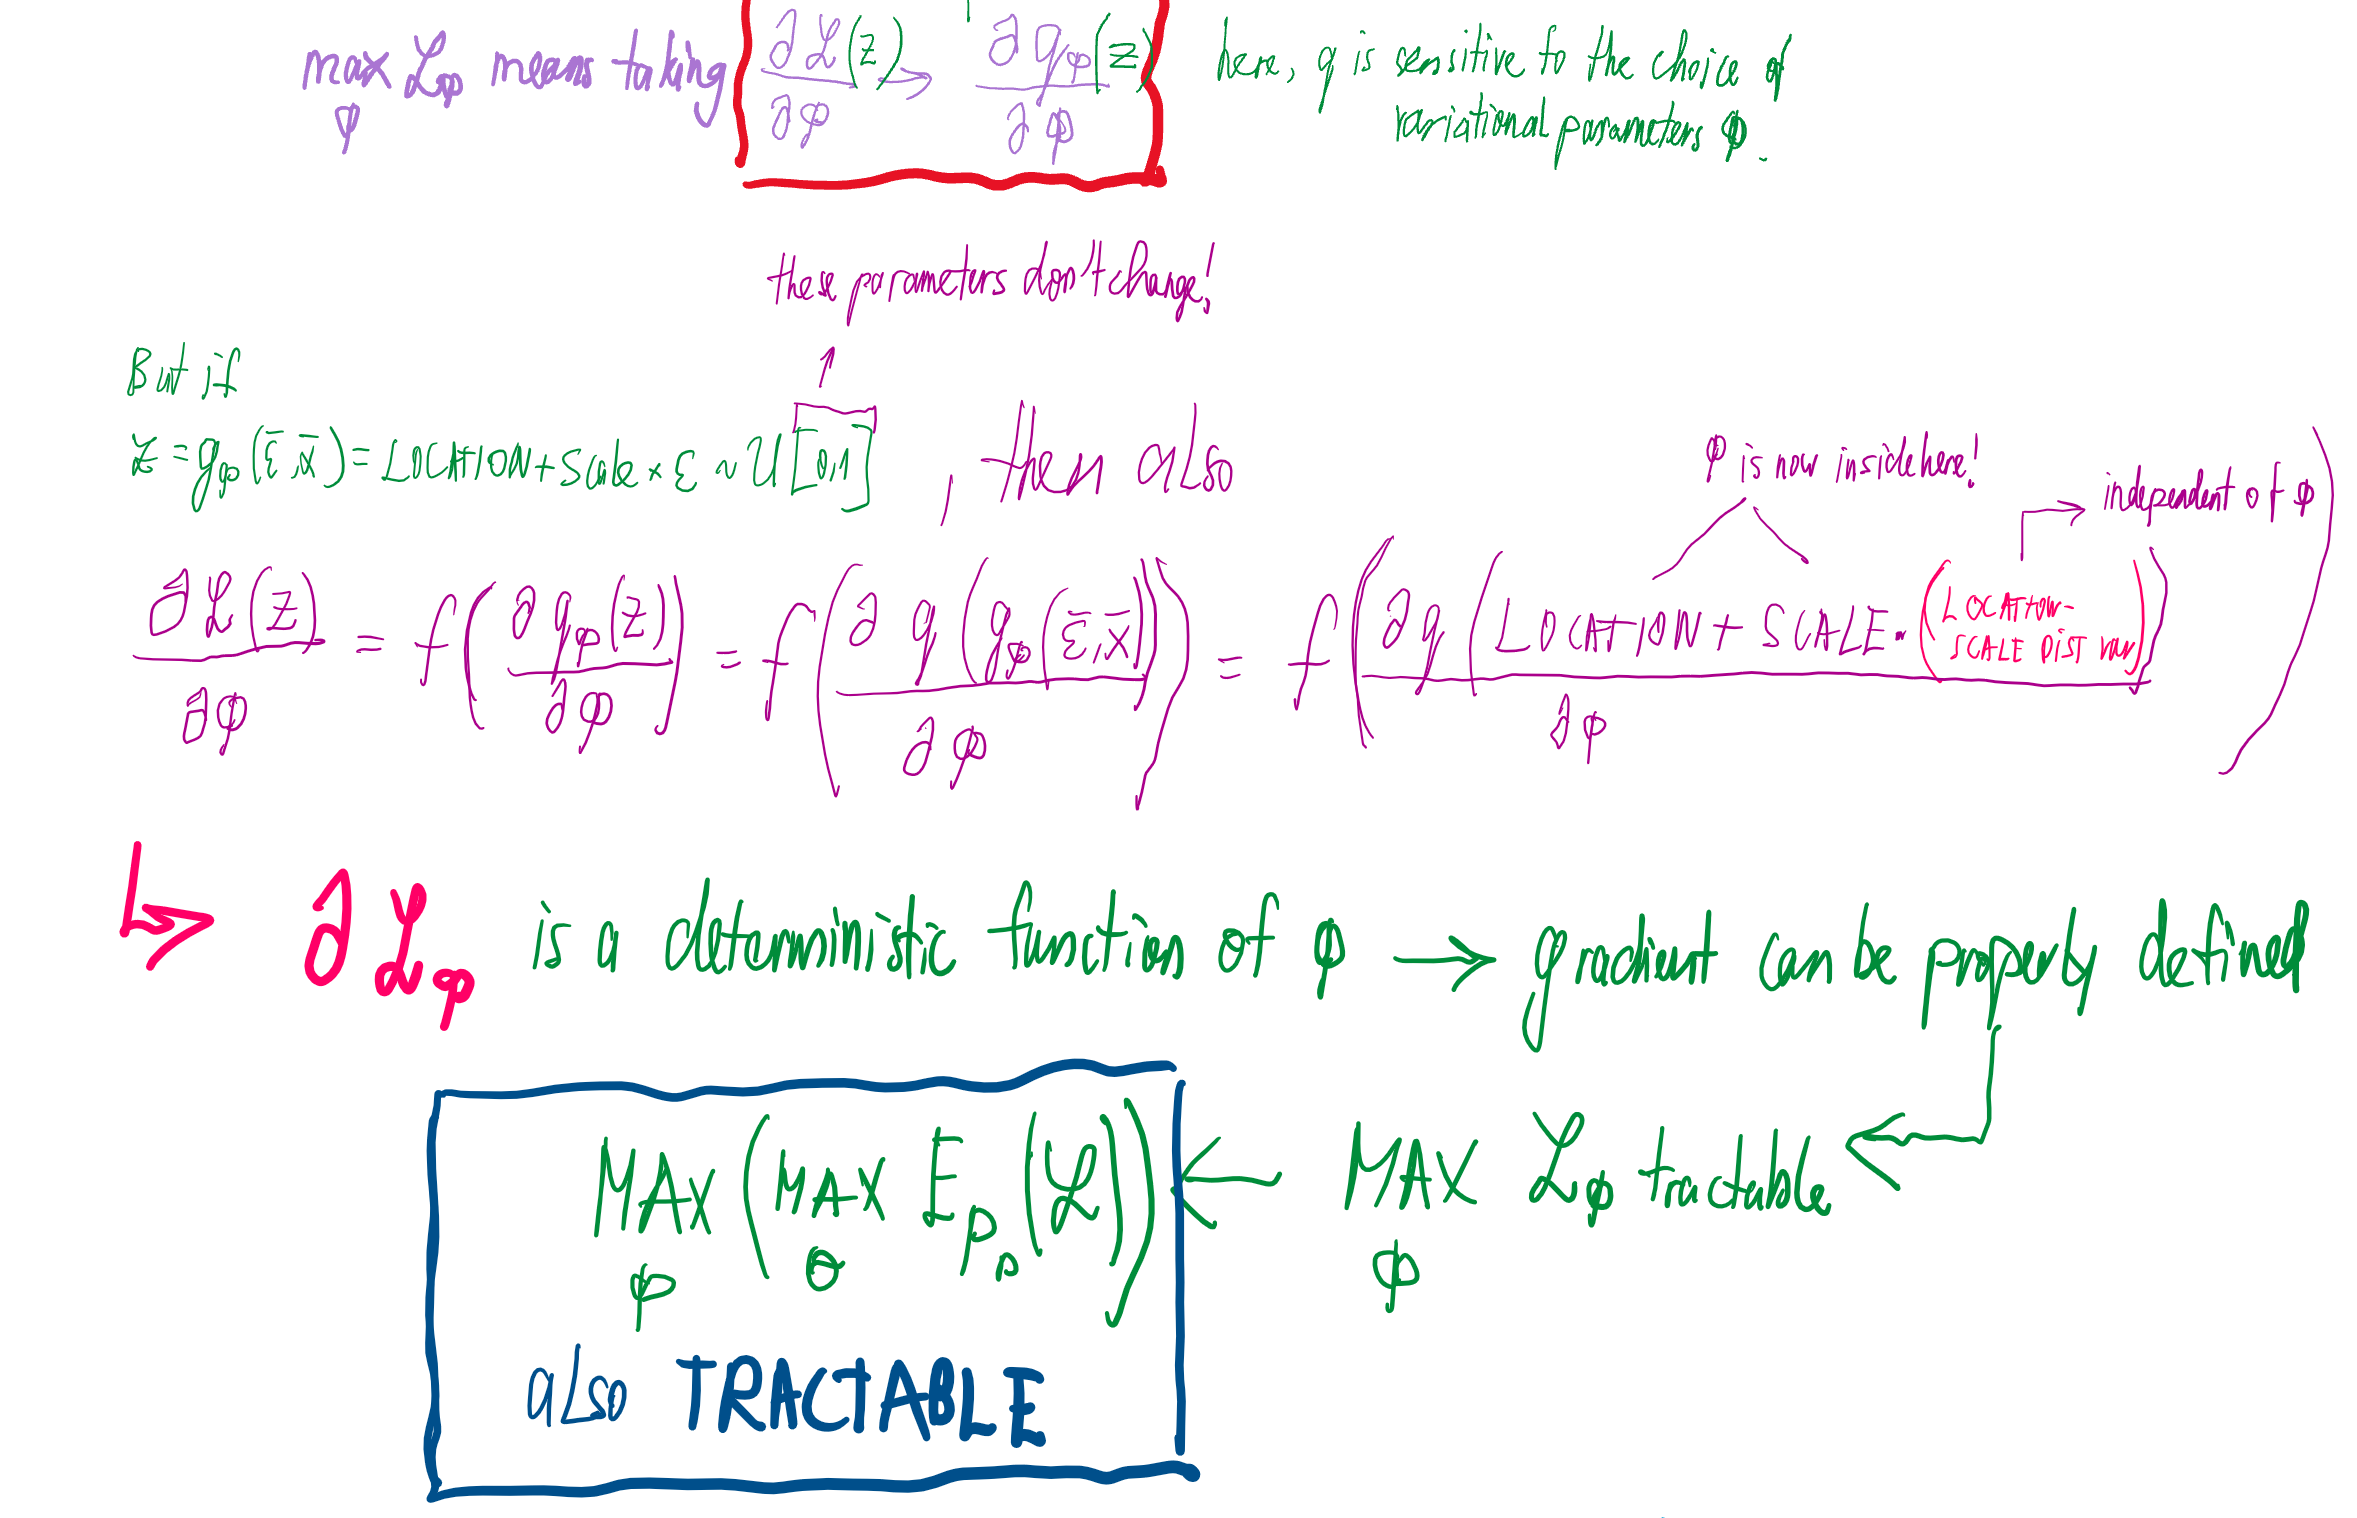

In [5]:
Image("img/reparam_trick.png")


In our model context this means that we can implement the reparametrization trick in the following form:

`  if self.training:
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
    else:
        return mu`

## Reparametrization Trick in TRAINING MODE:

That means that given a particular batch of data that has associated mean and variance functions (arrays) related to it (i.e. mean and variance are for each data point), we can invert the logarithm of variance (2x logarithm of std),  to find the standard deviation function (array) per batch, **parametrized by our neural network** and by using the location-family scaling, we can sample data of the same size as the batch from the standard normal distribution and store it as a Pytorch variable.

#### Additional Explanations
Do the means and variances refer to global means and variances?
Remember from before that every x value has its own mean and variance associated with it - so if we have n data points, we learn n means and n covariances.
Adding $\mu$ and $\sigma$, we can get any arbitrary distribution from the *location-scale* family of distributions and now the **optimization procedure is independent  of sampling parametrization (variational distribution parameters)** because every time a new sample is drawn, the same distribution is used (standard normal distribution), thus derivatives with respect to these parameters don't change over the samples (contrast to drawing samples from distributions that have different parameters).

## Reparametrization trick in TESTING MODE:
The  mean function of the data is returned, as this gives the highest probably location for the data. Note that this sampling is deterministic, thus also differentiable.

In [5]:
import os
os.makedirs("student_model")

In [13]:
#%%writefile student_model/student_vae.py

#pip install ipykernel ipython jupyter_client jupyter_core traitlets ipython_genutils

import numpy as np

representation_size = 2
input_size = 4
n_samples = 2000
batch_size = 5
n_samples_per_batch = n_samples//input_size

y = np.array([i for i in range(input_size)  for _ in range(n_samples_per_batch)])

d = np.identity(input_size)
x = np.array([d[i] for i in y], dtype=np.float32)

import torch
from torch import nn
from torch.autograd import Variable
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.en1 = nn.Linear(in_features = input_size, out_features = 200)
        self.en_mu = nn.Linear(in_features = 200, out_features = representation_size)
        self.en_std = nn.Linear(in_features = 200, out_features = representation_size)
        self.de1 = nn.Linear(in_features = representation_size, out_features = 200)
        self.de2 = nn.Linear(in_features = 200, out_features = input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        """Encode a batch of samples, and return posterior parameters for each point."""
        h1 = self.relu(self.en1(x))
        return self.en_mu(h1), self.en_std(h1)
    
    def decode(self, z):
        """Decode a batch of latent variables"""
        
        h2 = self.relu(self.de1(z))
        return self.sigmoid(self.de2(h2))
    
    def reparam(self, mu, logvar):
        """Reparameterisation trick to sample z values. 
        This is stochastic during training,  and returns the mode during evaluation."""
        
        if self.training:
            print("Logarithm of the variance is")
            print(logvar)
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_()) # sample as
            print("THe size of the standard deviation is")
            print(std.size())
            print("The sampled data under STD has size")
            print(eps.size())
            sampled_values_from_normal = eps.mul(std).add_(mu)
            print(sampled_values_from_normal)
            #print(sampled_values_from_normal.shape)
            return sampled_values_from_normal
        else:
            return mu
            
    def forward(self, x):
        """Takes a batch of samples, encodes them, and then decodes them again to compare."""
        mu, logvar = self.encode(x.view(-1, input_size))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss(self, reconstruction, x, mu, logvar):
        """ELBO assuming entries of x are binary variables, with closed form KLD."""
        bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, input_size))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= x.view(-1, input_size).data.shape[0] * input_size

        return bce + KLD
    
    def get_z(self, x):
        """Encode a batch of data points, x, into their z representations."""
        mu, logvar = self.encode(x.view(-1, input_size))
        return self.reparam(mu, logvar)


In [9]:
#!ls student_model
from student_model.student_vae import VAE
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
x

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [15]:
def train(epoch, batches_per_epoch = 501, log_interval=500):
    model.train()
    
    ind = np.arange(x.shape[0]) # 500 n_samples_per_batch, 2000 samples in total, so generate 2000 indices
    for i in range(batches_per_epoch): # for each batch of data 
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)]) # TAKE ALL THE DATA, SUBSET IT TO 5 data points in batch
        data = Variable(data, requires_grad=False) # Create a Pytorch Variable, computational graph, with data flowing through it
        optimizer.zero_grad() # Zero the gradients to avoid unwished accumulation
        batch_decoded, mu, logvar = model(data) # instiantiating the model -- output of the forward step
        # as a result we have the data decoded from the autoencoder, 
        # together with the mean vector and variance vector 
        loss = model.loss(batch_decoded, data, mu, logvar)
        loss.backward()
        #train_loss += loss.data[0]
        optimizer.step()
        if (i % log_interval == 0) and (epoch % 5 ==0):
           #Print progress
           print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
               epoch, i * batch_size, batch_size*batches_per_epoch,
               loss.data[0] / len(data)))

    print('====> Epoch: {} done!'.format(
          epoch))


def test(epoch, batches_per_epoch=1):
    model.eval()

    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        recon_batch, mu, logvar = model(data)
        if i == 0:
            n = min(data.size(0), 2)
            print(data.view(batch_size, 2,2)[:n])
            print(recon_batch.view(batch_size, 2,2)[:n])
            
            
print_examples = False #Change to true if you want to see some examples at each step!
for epoch in range(1, 30):
    train(epoch)
    if print_examples:
        test(epoch)

Logarithm of the variance is
tensor([[ 0.1334,  0.0507],
        [ 0.0978, -0.0251],
        [ 0.0119,  0.1505],
        [-0.1784,  0.0454],
        [ 0.0978, -0.0251]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 2.9314, -1.1344],
        [ 0.3514,  0.7825],
        [-0.3412, -1.4040],
        [ 0.6269,  0.7868],
        [ 0.9824,  2.3297]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[ 0.1130,  0.0201],
        [ 0.1130,  0.0201],
        [ 0.1130,  0.0201],
        [-0.0200,  0.1060],
        [-0.1901,  0.0060]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.2213, -0.6520],
        [-1.1059,  0.1998],
        [-0.6243,  0.5005],
        [ 0.8403, -0.3504],
        [ 0.5080,  0.8460]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[ 0.0838, -0.0080],

tensor([[ 0.0523, -0.0941],
        [-0.0087, -0.0370],
        [ 0.0522,  0.0808],
        [ 0.0523, -0.0941],
        [ 0.0522,  0.0808]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.7590,  0.1257],
        [-1.6755,  1.6395],
        [ 0.8032,  0.9919],
        [-0.2993,  0.3076],
        [-0.4970, -1.1887]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[ 0.0360,  0.0549],
        [ 0.0360,  0.0549],
        [ 0.0360,  0.0549],
        [ 0.0547, -0.1054],
        [ 0.0547, -0.1054]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.4633,  0.2924],
        [ 0.3072,  0.2759],
        [ 0.1158,  1.7239],
        [ 0.8061, -0.0843],
        [ 1.2136,  1.2683]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[0.0372, 0.0443],
        [0.0372, 0.0443],
    

Logarithm of the variance is
tensor([[-0.1898, -0.1683],
        [-0.0260,  0.0530],
        [-0.0801,  0.0029],
        [-0.0260,  0.0530],
        [-0.1614, -0.1762]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.4272,  1.1849],
        [ 1.5994,  1.0092],
        [-0.2283, -0.0893],
        [ 0.9458,  0.5759],
        [-0.6082,  0.0165]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.0719,  0.0005],
        [-0.0719,  0.0005],
        [-0.1565, -0.1775],
        [-0.0719,  0.0005],
        [-0.1857, -0.1709]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.2902,  1.2122],
        [ 0.8953,  0.1859],
        [-1.3694, -0.3741],
        [-0.7166,  0.1762],
        [-1.7422, -0.0792]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1827, -0.1714],

Logarithm of the variance is
tensor([[-0.1122,  0.0935],
        [-0.1122,  0.0935],
        [-0.1039,  0.0145],
        [-0.0771,  0.0604],
        [-0.1941, -0.1429]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.7920,  0.7607],
        [-0.5378,  0.8274],
        [-1.4625,  1.4203],
        [ 1.2651, -1.7029],
        [ 0.4022,  0.6691]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1069,  0.0237],
        [-0.1119,  0.0948],
        [-0.1069,  0.0237],
        [-0.1969, -0.1386],
        [-0.1119,  0.0948]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.3800,  0.0197],
        [-1.6217,  2.1284],
        [-1.4732, -0.6932],
        [ 1.7748, -0.0501],
        [ 0.7577,  2.8474]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.0819,  0.0467],

tensor([[-0.0477,  0.0513],
        [-0.0978,  0.0622],
        [-0.0718,  0.0455],
        [-0.0978,  0.0622],
        [-0.0718,  0.0455]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.3128, -0.1564],
        [ 0.7779, -0.4088],
        [ 1.1726,  1.0537],
        [ 0.7944, -1.9362],
        [-1.0525, -1.0480]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.0655,  0.0474],
        [-0.1191,  0.0604],
        [-0.0840,  0.0454],
        [-0.0840,  0.0454],
        [-0.0840,  0.0454]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.6489, -0.1286],
        [ 0.3158, -0.0194],
        [ 0.5878,  0.6286],
        [ 0.0994, -1.1542],
        [ 0.6748,  1.4250]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.0932,  0.0427],
        [-0.1599, -0.1094],


Logarithm of the variance is
tensor([[-0.0909, -0.1111],
        [-0.0947, -0.2621],
        [-0.0909, -0.1111],
        [-0.0976, -0.1486],
        [-0.0909, -0.1111]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.5315,  0.4342],
        [-0.7702,  1.3561],
        [-0.3768, -1.4443],
        [-0.3815,  0.3816],
        [ 0.0980, -0.7533]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1012, -0.1005],
        [-0.1117, -0.1418],
        [-0.1012, -0.1005],
        [-0.1012, -0.1005],
        [-0.1012, -0.1005]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.4975,  0.3075],
        [ 0.4599,  0.4671],
        [-0.8350, -1.8058],
        [-0.3889, -1.8490],
        [ 0.3229, -1.5923]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1165, -0.2422],

THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.0369,  1.3923],
        [-0.9308, -0.1008],
        [-0.2555, -0.7837],
        [-1.1738, -1.0536],
        [ 1.5591, -0.7620]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1124, -0.0405],
        [-0.1951, -0.2279],
        [-0.1157,  0.0133],
        [-0.1124, -0.0405],
        [-0.1157,  0.0133]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.5081, -2.7718],
        [ 0.5011, -1.1604],
        [ 0.4522, -0.8196],
        [-0.4736,  0.3860],
        [ 0.4312,  1.3909]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.0957, -0.0419],
        [-0.0957, -0.0419],
        [-0.1847, -0.2324],
        [-0.1847, -0.2324],
        [-0.0957, -0.0419]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])

torch.Size([5, 2])
tensor([[-1.8525, -0.9144],
        [-1.9311,  2.1171],
        [ 2.0220,  0.6872],
        [ 1.6564,  0.8344],
        [ 0.5808, -0.0900]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.0522,  0.0082],
        [-0.0718, -0.0391],
        [-0.1480, -0.0574],
        [-0.1480, -0.0574],
        [-0.1480, -0.0574]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.7155, -1.0143],
        [-0.3133, -1.2632],
        [ 0.3366,  2.6885],
        [-1.3017,  0.4402],
        [ 0.3290,  0.5192]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1356, -0.2472],
        [-0.1356, -0.2472],
        [-0.0801, -0.0101],
        [-0.0801, -0.0101],
        [-0.1471, -0.0245]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.3930, -1.9753],
        [

Logarithm of the variance is
tensor([[-0.2084, -0.2799],
        [-0.1160, -0.2227],
        [-0.1375, -0.1299],
        [-0.1251, -0.3133],
        [-0.1160, -0.2227]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.0900, -0.6886],
        [ 0.5767, -0.6994],
        [ 0.8687, -1.2946],
        [-0.3145, -1.5698],
        [-0.0209, -0.5612]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1385, -0.1156],
        [-0.1385, -0.1156],
        [-0.2075, -0.2651],
        [-0.1172, -0.2169],
        [-0.1237, -0.3020]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 1.1689, -0.1024],
        [-0.1686, -1.9104],
        [ 0.5419, -0.2563],
        [-1.3373, -0.9672],
        [-1.0507, -0.9584]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1130, -0.2195],

THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.1008,  2.1513],
        [-1.3863,  1.2836],
        [ 1.6441, -0.7865],
        [-0.7516, -0.9920],
        [ 1.1220, -2.3576]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.0970, -0.1423],
        [-0.3080, -0.2756],
        [-0.0970, -0.1423],
        [-0.3080, -0.2756],
        [-0.2701, -0.1469]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.0522,  0.6257],
        [ 1.1092,  1.9028],
        [-1.4748,  1.6317],
        [-0.0527, -0.8175],
        [ 0.6763, -0.7924]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2577, -0.1543],
        [-0.2577, -0.1543],
        [-0.2577, -0.1543],
        [-0.2867, -0.3010],
        [-0.0774, -0.1524]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])

Logarithm of the variance is
tensor([[-0.3689, -0.5124],
        [-0.1486, -0.3075],
        [-0.3802, -0.4117],
        [-0.2438, -0.3300],
        [-0.3689, -0.5124]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.4214,  0.3075],
        [ 0.5714,  1.0464],
        [-1.6742, -0.7996],
        [-0.8783,  0.5102],
        [-0.0240,  0.7402]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1502, -0.3125],
        [-0.1502, -0.3125],
        [-0.2448, -0.3342],
        [-0.1502, -0.3125],
        [-0.2448, -0.3342]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.2067,  0.3826],
        [-1.2635, -0.1416],
        [-0.6638,  1.7626],
        [ 1.1563, -1.0030],
        [-0.5465,  1.6059]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2464, -0.3300],

tensor([[ 0.1096,  3.1573],
        [-1.0177,  0.4843],
        [-0.4460,  1.7042],
        [-0.9028, -0.4004],
        [-0.1138, -1.5282]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.4107, -0.5983],
        [-0.2659, -0.6171],
        [-0.2659, -0.6171],
        [-0.4107, -0.5983],
        [-0.3059, -0.6242]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.0395, -1.0682],
        [-0.3376, -0.2147],
        [ 0.4770, -1.1789],
        [-0.9456, -0.5483],
        [ 1.2094, -1.3083]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2317, -0.2820],
        [-0.2317, -0.2820],
        [-0.2317, -0.2820],
        [-0.2317, -0.2820],
        [-0.2317, -0.2820]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.5844,  1.8710],
        [ 0.2815,  0.3059],


Logarithm of the variance is
tensor([[-0.0406, -0.2523],
        [-0.1050, -0.3161],
        [-0.0406, -0.2523],
        [-0.0406, -0.2523],
        [-0.0930, -0.3902]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.6317,  2.2410],
        [ 0.1944,  0.0743],
        [-0.8091,  1.9172],
        [ 0.1071,  0.1500],
        [-1.7924, -0.5584]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1705, -0.3892],
        [-0.0402, -0.2540],
        [-0.0887, -0.3852],
        [-0.0968, -0.3055],
        [-0.0402, -0.2540]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.0826, -1.1042],
        [-1.5733,  1.1934],
        [ 1.2890, -1.1299],
        [ 0.7755, -0.0901],
        [ 0.0240,  1.8981]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.0952, -0.2923],

Logarithm of the variance is
tensor([[-0.2249, -0.2781],
        [-0.2249, -0.2781],
        [-0.4146, -0.7174],
        [-0.2014, -0.4497],
        [-0.1846, -0.5864]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 1.3806, -0.7174],
        [ 0.9659,  0.9610],
        [ 0.8973, -0.4501],
        [ 0.5676,  0.0939],
        [ 0.0330,  0.5428]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.4178, -0.7126],
        [-0.2073, -0.4502],
        [-0.4178, -0.7126],
        [-0.1829, -0.5806],
        [-0.2327, -0.2726]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.4348,  0.5115],
        [-1.0316,  0.5062],
        [-1.4072, -0.1510],
        [-1.0091, -0.3568],
        [ 1.7813, -0.1294]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1784, -0.5732],

Logarithm of the variance is
tensor([[-0.0479, -0.4074],
        [-0.3558, -0.1947],
        [-0.0479, -0.4074],
        [-0.2975, -0.5066],
        [-0.2975, -0.5066]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.3984,  0.0415],
        [ 0.1939, -1.7676],
        [-2.0320, -0.2121],
        [ 0.0105, -0.3694],
        [ 1.1399,  0.4307]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1177, -0.4517],
        [-0.0437, -0.4037],
        [-0.1177, -0.4517],
        [-0.1177, -0.4517],
        [-0.2892, -0.5015]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.6601,  1.8485],
        [ 0.5161,  0.2365],
        [ 0.1336,  2.2435],
        [ 0.6492,  2.9535],
        [-0.9147, -0.8751]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1143, -0.4437],

Logarithm of the variance is
tensor([[-0.3455, -0.2530],
        [-0.3455, -0.2530],
        [-0.3726, -0.4924],
        [-0.4574, -0.5150],
        [-0.3455, -0.2530]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.2161, -1.5617],
        [-1.2439,  2.3445],
        [-0.2547,  1.1272],
        [-1.9887, -0.7084],
        [ 0.6037,  0.0333]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.4507, -0.5253],
        [-0.5475, -0.5337],
        [-0.4507, -0.5253],
        [-0.3704, -0.5055],
        [-0.5475, -0.5337]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.5839,  0.1917],
        [ 0.7575,  0.6513],
        [-2.2291, -0.2641],
        [-1.4526,  1.7644],
        [ 0.4392, -0.2114]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.3636, -0.5148],

tensor([[-0.8699,  1.2998],
        [-1.2444,  0.2052],
        [-0.2807,  0.4928],
        [ 0.5216, -0.5984],
        [ 0.6268, -0.9878]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.4867, -0.7463],
        [-0.4867, -0.7463],
        [-0.4867, -0.7463],
        [-0.6931, -0.7435],
        [-0.6931, -0.7435]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-2.0753, -0.5938],
        [-1.5445, -1.0666],
        [-1.9616, -0.5948],
        [-0.2137, -0.1915],
        [-0.2496,  1.4495]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.4837, -0.7787],
        [-0.4837, -0.7787],
        [-0.4837, -0.7787],
        [-0.6885, -0.7722],
        [-0.4837, -0.7787]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.0857, -0.3871],
        [-1.7310, -1.2719],


tensor([[-0.4566, -0.7714],
        [-0.5924, -0.3928],
        [-0.5924, -0.3928],
        [-0.3019, -0.8335],
        [-0.5924, -0.3928]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.9497, -1.9145],
        [ 0.7526, -0.5910],
        [ 2.2747,  0.0202],
        [-0.7543,  1.1601],
        [ 1.9181, -1.3941]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.4573, -0.7777],
        [-0.5879, -0.3903],
        [-0.4573, -0.7777],
        [-0.6467, -0.7477],
        [-0.2919, -0.8390]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.6071, -0.3300],
        [ 1.1100, -1.2120],
        [-1.0216, -0.8131],
        [ 0.1491, -0.1463],
        [ 0.3937,  1.5055]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.5811, -0.3833],
        [-0.2802, -0.8380],


tensor([[-1.0333, -1.5342],
        [-0.7276, -0.3435],
        [-0.4309,  0.4968],
        [ 1.8164, -0.0636],
        [ 0.4000, -0.3746]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.7749, -0.5971],
        [-0.7233, -0.5248],
        [-0.3503, -0.5702],
        [-0.7749, -0.5971],
        [-0.7233, -0.5248]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.5769, -0.4343],
        [-0.4830, -1.2679],
        [-0.1032,  1.0561],
        [-0.7324, -0.5631],
        [-1.0792, -2.0565]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.3593, -0.5722],
        [-0.7911, -0.5997],
        [-0.6342, -0.1721],
        [-0.3593, -0.5722],
        [-0.3593, -0.5722]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.8045,  1.9538],
        [ 0.8338, -0.0879],


tensor([[-0.5796, -0.7750],
        [-0.5796, -0.7750],
        [-0.5796, -0.7750],
        [-0.7294, -0.5688],
        [-0.5796, -0.7750]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.1287, -1.4489],
        [-0.7517, -1.0978],
        [-2.7740, -1.2647],
        [ 0.6336, -1.8206],
        [-1.7115,  0.3174]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.3482, -0.9307],
        [-0.5763, -0.7694],
        [-0.5763, -0.7694],
        [-0.8975, -0.8419],
        [-0.3482, -0.9307]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.5842,  0.7252],
        [-2.2463, -0.5863],
        [-1.2207, -0.2789],
        [-0.3254, -1.5511],
        [-0.4124,  2.0255]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.8904, -0.8398],
        [-0.7143, -0.5738],


tensor([[-1.7760, -0.1547],
        [ 3.3077,  0.7560],
        [ 1.5983, -0.0915],
        [-1.4359, -0.2231],
        [-1.0994, -0.8486]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.9424, -0.8412],
        [-0.5739, -0.7261],
        [-0.5739, -0.7261],
        [-0.4275, -0.8354],
        [-0.9424, -0.8412]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.5225,  0.5406],
        [-1.3929, -1.2499],
        [-0.9112, -1.0536],
        [-1.1795,  0.2638],
        [-0.1385, -1.3142]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.5709, -0.7315],
        [-0.4315, -0.8419],
        [-0.4315, -0.8419],
        [-0.9518, -0.8449],
        [-0.5709, -0.7315]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.0632,  0.4516],
        [-0.7015,  1.9999],


Logarithm of the variance is
tensor([[-0.9123, -0.6375],
        [-0.8219, -0.1649],
        [-0.9123, -0.6375],
        [-0.9123, -0.6375],
        [-0.8219, -0.1649]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.5805, -0.7077],
        [ 1.0557, -0.6614],
        [ 0.4482,  0.6184],
        [ 1.0385, -0.4237],
        [ 2.1109, -1.0911]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.6681, -0.6280],
        [-0.9145, -0.6272],
        [-0.9145, -0.6272],
        [-0.8224, -0.1519],
        [-0.8224, -0.1519]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.8053, -0.1737],
        [ 0.8067, -0.2604],
        [ 0.6695,  0.7643],
        [ 0.6015,  0.0794],
        [ 1.0280, -0.3123]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.6729, -0.6148],

THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 1.4914,  0.8715],
        [-0.1276,  0.3195],
        [ 0.2389, -0.1084],
        [ 0.7168,  0.4194],
        [ 0.0556,  1.7591]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.6387, -0.6060],
        [-0.8240, -0.8280],
        [-0.6387, -0.6060],
        [-0.6387, -0.6060],
        [-0.2513, -0.9056]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.4794, -1.0441],
        [ 1.5054,  1.2306],
        [-1.0054, -0.0356],
        [-0.5689, -0.2084],
        [ 0.2669,  2.0148]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.7006, -0.3728],
        [-0.6346, -0.6045],
        [-0.8232, -0.8320],
        [-0.8232, -0.8320],
        [-0.2471, -0.9115]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])

tensor([[-0.7914,  0.1208],
        [-0.9721,  0.3866],
        [ 0.1433,  0.0529],
        [-2.1443,  1.8964],
        [-1.8618, -1.4017]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.1637, -0.9746],
        [-1.1637, -0.9746],
        [-0.9139, -0.6303],
        [-0.9139, -0.6303],
        [-0.5029, -1.0942]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.8173,  0.5282],
        [ 0.6310, -0.4530],
        [-1.7746, -0.5600],
        [-0.7772, -0.3284],
        [-1.1073,  0.9359]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.1695, -0.9783],
        [-0.9530, -0.4449],
        [-0.9228, -0.6312],
        [-1.1695, -0.9783],
        [-0.9228, -0.6312]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.9107, -0.5122],
        [ 0.5035,  0.0788],


tensor([[ 2.3550, -0.6641],
        [ 0.3143,  0.3109],
        [-1.1394, -0.1062],
        [ 1.0921, -0.9223],
        [-0.7609, -0.4070]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.9874, -0.8553],
        [-0.7904, -0.5359],
        [-0.7901, -0.3670],
        [-0.9874, -0.8553],
        [-0.9874, -0.8553]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.0088, -0.8438],
        [-0.9192, -1.1169],
        [ 0.0486, -0.4925],
        [ 0.2855, -0.1441],
        [ 0.5314, -0.4850]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.7821, -0.5316],
        [-0.2150, -0.9246],
        [-0.9802, -0.8502],
        [-0.9802, -0.8502],
        [-0.7854, -0.3655]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-2.1154, -1.0896],
        [-1.3708,  1.1368],


Logarithm of the variance is
tensor([[-0.8775, -0.9123],
        [-0.1273, -0.9573],
        [-0.8775, -0.9123],
        [-0.1273, -0.9573],
        [-0.6405, -0.6071]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.0219,  0.3522],
        [-1.4311,  1.8017],
        [ 0.3304,  0.5373],
        [-0.7667,  1.9981],
        [-1.0938, -0.1260]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.8749, -0.9206],
        [-0.8749, -0.9206],
        [-0.6904, -0.5057],
        [-0.6904, -0.5057],
        [-0.1300, -0.9573]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.0204,  0.0882],
        [-1.2780, -0.3110],
        [ 1.3320, -1.9003],
        [ 0.3396, -1.5965],
        [-0.2902,  2.5297]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.6504, -0.6216],

THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.4347, -0.6231],
        [-0.6265,  0.4869],
        [-0.8766, -0.2733],
        [ 1.5294,  0.0983],
        [-1.3905, -0.6148]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.7366, -0.4950],
        [-0.8386, -0.5047],
        [-0.4491, -0.7743],
        [-0.7366, -0.4950],
        [-0.7366, -0.4950]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.9586, -1.0375],
        [-1.0357, -1.2469],
        [ 0.3507,  1.2862],
        [ 0.0650, -0.0432],
        [ 1.0863, -1.3215]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.2140, -0.9477],
        [-0.4417, -0.7531],
        [-0.7316, -0.4802],
        [-0.8398, -0.4841],
        [-0.7316, -0.4802]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])

tensor([[-0.6838,  0.3769],
        [ 0.5964,  2.5159],
        [ 0.5597, -0.4282],
        [ 0.6671, -0.3927],
        [-2.6853, -1.5471]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.7329, -0.5902],
        [-0.2019, -0.9217],
        [-0.6648, -0.6396],
        [-0.2019, -0.9217],
        [-0.2019, -0.9217]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 1.3046, -0.7133],
        [-0.7642,  0.6986],
        [-1.4835, -0.9590],
        [ 0.8894,  0.9983],
        [-1.5570,  1.4505]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2027, -0.9236],
        [-1.1486, -1.1240],
        [-0.2027, -0.9236],
        [-0.7478, -0.5916],
        [-0.2027, -0.9236]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.4155, -0.0768],
        [-0.3412, -1.1860],


Logarithm of the variance is
tensor([[-0.8045, -0.5621],
        [-1.2013, -1.2481],
        [-1.2013, -1.2481],
        [-0.5875, -0.8382],
        [-1.2013, -1.2481]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 2.0167, -0.4382],
        [-0.4355,  0.3670],
        [-0.3722,  0.8034],
        [-0.0257,  0.3999],
        [-0.7336, -0.9864]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.5836, -0.8412],
        [-0.8006, -0.5620],
        [-1.2059, -1.2629],
        [-0.1180, -1.0662],
        [-0.5836, -0.8412]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.0115, -0.6626],
        [ 1.6640,  0.6284],
        [ 0.2855, -0.5768],
        [-0.4387,  3.0502],
        [-1.8447, -0.6054]], grad_fn=<AddBackward0>)
====> Epoch: 2 done!
Logarithm of the variance is
tensor

Logarithm of the variance is
tensor([[-0.3424, -0.9909],
        [-0.7680, -0.7542],
        [-0.3424, -0.9909],
        [-0.7680, -0.7542],
        [-0.8418, -0.6880]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-8.1071e-01,  1.9176e+00],
        [-1.2644e+00, -9.7050e-01],
        [ 1.1791e+00,  1.0960e+00],
        [-9.1919e-01, -1.3588e-03],
        [ 9.3240e-01, -6.4496e-01]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.3344, -0.9905],
        [-0.3344, -0.9905],
        [-0.8315, -0.6865],
        [-0.3344, -0.9905],
        [-1.3219, -1.2881]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.8805,  1.5525],
        [-0.4016,  1.2857],
        [ 0.0899,  0.3213],
        [-0.5076,  1.5246],
        [ 1.4248, -0.9568]], grad_fn=<AddBackward0>)
Logarithm of the

Logarithm of the variance is
tensor([[-0.8366, -0.4788],
        [-0.8366, -0.4788],
        [-0.2630, -0.8545],
        [-0.8366, -0.4788],
        [-1.3736, -1.2117]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 1.0170,  0.0975],
        [ 1.6617, -1.4361],
        [ 0.7946,  1.3372],
        [ 3.0007, -1.1283],
        [ 0.0153,  0.1642]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.8454, -0.4832],
        [-0.7565, -0.6824],
        [-0.2714, -0.8750],
        [-1.3799, -1.2245],
        [-0.7565, -0.6824]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 1.6287, -0.4693],
        [-1.3751, -0.5487],
        [-1.2855,  1.5847],
        [ 0.1139, -0.3832],
        [-1.8192, -0.4112]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.3811, -1.2327],

tensor([[ 0.6284, -0.1256],
        [-0.3748,  0.6063],
        [ 0.2413, -0.0031],
        [-1.9122,  0.1551],
        [ 0.6352,  0.1191]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.3916, -1.1239],
        [-1.3916, -1.1239],
        [-1.3916, -1.1239],
        [-0.8396, -0.3507],
        [-0.2953, -0.8655]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.4147, -0.9461],
        [ 0.2192, -0.3151],
        [ 0.2611, -0.7880],
        [ 1.4123, -1.1917],
        [-0.1798,  1.2746]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.8519, -0.3418],
        [-0.2962, -0.8585],
        [-0.2962, -0.8585],
        [-0.2962, -0.8585],
        [-0.8519, -0.3418]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 1.7389,  0.3810],
        [-0.1067,  0.6939],


Logarithm of the variance is
tensor([[-0.8436, -0.7417],
        [-0.2928, -1.1490],
        [-0.2928, -1.1490],
        [-0.2928, -1.1490],
        [-1.4122, -1.3491]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.6768, -1.0223],
        [-0.2994,  1.0458],
        [-1.0129,  0.2756],
        [ 0.4028,  0.8885],
        [ 0.4748, -0.1253]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2863, -1.1516],
        [-0.2863, -1.1516],
        [-1.4095, -1.3512],
        [-1.4095, -1.3512],
        [-1.4095, -1.3512]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.0913,  0.0041],
        [-0.4925,  0.6942],
        [-0.4075,  0.9766],
        [-0.3582, -1.0224],
        [ 0.4150,  0.1786]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.8344, -0.7455],

Logarithm of the variance is
tensor([[-0.8277, -0.9166],
        [-0.9348, -0.6939],
        [-0.8277, -0.9166],
        [-0.2270, -1.2748],
        [-0.2270, -1.2748]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.6473,  0.1863],
        [ 1.3165, -1.2222],
        [-0.5316, -1.0003],
        [ 0.9783,  0.1384],
        [ 0.1220,  1.2552]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.8329, -0.9065],
        [-0.2372, -1.2736],
        [-0.8329, -0.9065],
        [-1.3948, -1.4788],
        [-1.3948, -1.4788]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.2042,  0.0943],
        [-1.0726,  0.7559],
        [-0.9330, -0.2185],
        [-0.3861,  0.3701],
        [-0.0714, -0.8702]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.8412, -0.8988],

tensor([[-0.1741, -0.9813],
        [-0.8087, -0.5198],
        [-0.1741, -0.9813],
        [-0.8087, -0.5198],
        [-1.3081, -1.3100]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.4539, -0.2844],
        [ 1.2571, -1.4385],
        [ 0.1689,  1.7603],
        [ 2.0195, -1.4788],
        [ 0.6000, -0.6911]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1716, -0.9729],
        [-0.8055, -0.5122],
        [-0.8055, -0.5122],
        [-0.8055, -0.5122],
        [-0.1716, -0.9729]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.4468,  0.3749],
        [ 0.8273, -1.9123],
        [ 0.4216, -1.3133],
        [ 0.8124, -0.4906],
        [ 1.1192,  0.0340]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.8052, -0.5100],
        [-0.7599, -0.5974],


tensor([[ 0.6753, -0.9699],
        [ 1.9454,  0.7251],
        [ 0.0334,  0.5503],
        [-0.9622, -0.5776],
        [ 0.9199, -1.9819]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.8031, -0.3503],
        [-0.2944, -0.9353],
        [-0.8031, -0.3503],
        [-0.8031, -0.3503],
        [-1.0717, -0.6273]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.3178, -1.6483],
        [-0.3064,  1.6678],
        [ 1.1052,  0.8566],
        [ 0.5047, -0.7062],
        [-1.0977, -0.3500]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.0911, -0.6536],
        [-1.0911, -0.6536],
        [-1.0911, -0.6536],
        [-0.3022, -0.9473],
        [-0.8173, -0.3699]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.6908, -0.6003],
        [-1.4818, -1.8574],


Logarithm of the variance is
tensor([[-0.2190, -1.1050],
        [-1.3330, -1.4921],
        [-0.7766, -0.5596],
        [-0.7766, -0.5596],
        [-0.7766, -0.5596]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.4599,  1.2339],
        [ 0.1198, -0.1578],
        [ 1.9191, -0.7793],
        [ 1.4469,  0.0533],
        [ 1.2075, -1.0233]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.3270, -1.4828],
        [-0.2149, -1.0897],
        [-1.3270, -1.4828],
        [-0.7739, -0.5461],
        [-0.7739, -0.5461]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.2308, -0.0541],
        [-1.0158,  1.4460],
        [-0.0855, -0.2643],
        [ 2.3284, -1.7125],
        [ 1.3142, -0.6721]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2082, -1.0726],

Logarithm of the variance is
tensor([[-0.2552, -1.0879],
        [-1.0353, -0.6343],
        [-0.6673, -0.5717],
        [-1.4091, -1.5487],
        [-1.0353, -0.6343]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.4433,  1.9308],
        [-0.4626, -1.4532],
        [ 1.4623, -1.0519],
        [-0.8248,  0.1627],
        [-1.0384, -0.3028]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2738, -1.0928],
        [-1.0445, -0.6370],
        [-0.2738, -1.0928],
        [-0.6753, -0.5688],
        [-0.6753, -0.5688]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.4463,  1.1886],
        [-0.7506, -1.3518],
        [-1.3395,  1.7224],
        [ 0.7015, -0.7410],
        [ 1.5580, -0.3308]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.4398, -1.5491],

Logarithm of the variance is
tensor([[-1.1266, -0.5450],
        [-0.8408, -0.3623],
        [-1.5759, -1.4781],
        [-0.8408, -0.3623],
        [-1.1266, -0.5450]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.1571,  0.5525],
        [ 1.0736,  0.2945],
        [-0.3711, -1.2625],
        [ 0.7630, -1.8018],
        [-0.8755, -0.8086]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.3181, -0.9918],
        [-0.8399, -0.3690],
        [-0.3181, -0.9918],
        [-1.5743, -1.4908],
        [-1.5743, -1.4908]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.1427,  1.7737],
        [ 1.4397, -0.4280],
        [-2.0815,  0.6698],
        [-0.0897,  0.9063],
        [ 0.0199, -0.3330]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.1167, -0.5752],

Logarithm of the variance is
tensor([[-0.3349, -1.2162],
        [-1.6091, -1.7202],
        [-1.6091, -1.7202],
        [-0.3349, -1.2162],
        [-1.6091, -1.7202]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.7294,  1.8702],
        [-0.0933,  0.1991],
        [-0.2435, -0.0319],
        [-1.3315,  0.3705],
        [ 0.2887, -0.1753]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.3331, -1.2199],
        [-1.6062, -1.7228],
        [-0.3331, -1.2199],
        [-1.6062, -1.7228],
        [-0.9821, -0.6725]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.5882,  0.8602],
        [-0.3618, -0.3887],
        [ 0.7497,  1.0144],
        [ 0.3290, -0.2551],
        [ 1.4376, -0.9909]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.9826, -0.6762],

The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 1.6846, -2.0055],
        [ 1.5689, -0.2142],
        [-1.0781, -1.3627],
        [-0.8448,  1.7599],
        [-1.4809, -0.0454]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.8414, -1.5549],
        [-0.3712, -1.1586],
        [-1.3145, -0.7100],
        [-1.3145, -0.7100],
        [-1.0829, -0.6168]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.0445,  0.3727],
        [-1.2240,  1.1230],
        [-0.7141, -0.2000],
        [-0.9973, -0.9503],
        [ 1.6118,  1.1138]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.3143, -0.7181],
        [-1.3143, -0.7181],
        [-0.3650, -1.1625],
        [-1.8403, -1.5598],
        [-1.0744, -0.6244]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
t

tensor([[-1.6547, -1.6942],
        [-1.6547, -1.6942],
        [-0.1033, -1.3705],
        [-1.1437, -0.8419],
        [-1.1437, -0.8419]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 4.8194e-01, -4.2830e-01],
        [-5.9054e-01, -1.7880e-01],
        [-3.0848e-01,  1.2522e+00],
        [-4.2306e-01, -1.1243e+00],
        [-1.3357e-03, -1.8859e+00]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.1582, -0.8383],
        [-0.1157, -1.3686],
        [-0.9259, -0.7611],
        [-1.1582, -0.8383],
        [-1.6630, -1.6907]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.7794,  0.5885],
        [-0.6145,  1.2913],
        [ 1.7480, -1.8208],
        [-1.5231, -0.9960],
        [ 0.5873,  0.8144]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.6700

tensor([[-1.1630, -0.6924],
        [-1.8367, -1.7662],
        [-0.9758, -0.6584],
        [-1.1630, -0.6924],
        [-0.2988, -1.2595]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.6170, -0.6977],
        [-0.1030,  0.6512],
        [ 0.5360, -0.5696],
        [-0.8257, -0.1930],
        [ 1.6223,  1.4164]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2921, -1.2516],
        [-0.2921, -1.2516],
        [-0.9724, -0.6534],
        [-0.2921, -1.2516],
        [-0.9724, -0.6534]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.4260,  1.9664],
        [ 0.0939,  1.6982],
        [ 1.5966,  0.0668],
        [ 0.0544,  1.7823],
        [ 0.4653, -1.2066]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.9679, -0.6458],
        [-0.9679, -0.6458],


tensor([[-0.7036, -0.5657],
        [-0.5936, -0.2635],
        [-0.1819,  0.3844],
        [-0.4403,  1.9126],
        [ 1.3337,  0.0344]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.3535, -1.4179],
        [-1.7992, -1.9086],
        [-1.7992, -1.9086],
        [-0.3535, -1.4179],
        [-1.7992, -1.9086]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.0542,  0.8166],
        [ 0.5696,  0.1574],
        [ 0.2726,  0.3016],
        [ 1.0283,  2.2955],
        [ 0.4054,  0.1016]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.3556, -1.4154],
        [-1.1480, -0.7130],
        [-1.7958, -1.8992],
        [-0.9861, -0.6782],
        [-0.9861, -0.6782]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.6271,  1.8098],
        [-1.4815, -1.6330],


tensor([[-1.9894, -1.1513],
        [-1.6987, -1.9417],
        [-0.0024, -0.0220],
        [ 0.2424,  0.0101],
        [-0.3039,  1.7486]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.3720, -1.3794],
        [-0.3720, -1.3794],
        [-1.1701, -0.6416],
        [-1.1701, -0.6416],
        [-1.1701, -0.6416]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.3939,  2.1049],
        [-0.1011,  0.7563],
        [-0.8298, -0.2463],
        [-1.2033, -2.4791],
        [-1.6559, -0.2241]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.1651, -0.6493],
        [-1.0246, -0.5397],
        [-1.7837, -1.7874],
        [-1.1651, -0.6493],
        [-0.3641, -1.3831]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.9540, -1.8846],
        [ 0.5467,  0.0144],


THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.2197,  0.4247],
        [-1.1764, -0.7615],
        [-0.9554,  0.9886],
        [-1.0436, -0.1710],
        [ 1.1769, -1.1080]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.2180, -0.8254],
        [-1.7586, -1.7690],
        [-1.7586, -1.7690],
        [-1.2180, -0.8254],
        [-1.2180, -0.8254]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.9094, -0.4337],
        [ 0.4231, -0.6809],
        [-0.1389,  0.2227],
        [-0.0305, -1.4076],
        [-1.5578, -1.1978]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.3734, -1.4552],
        [-1.7501, -1.7699],
        [-1.2151, -0.8274],
        [-1.7501, -1.7699],
        [-0.3734, -1.4552]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])

tensor([[-2.1744, -0.5653],
        [ 0.0999, -0.3275],
        [-0.0283,  1.9954],
        [-0.9889,  0.4509],
        [ 0.4116, -0.0455]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2700, -1.3068],
        [-1.2338, -0.5609],
        [-1.1341, -0.4652],
        [-1.7067, -1.5340],
        [-1.1341, -0.4652]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.1633,  1.5487],
        [-1.3913, -0.1307],
        [ 1.3713, -0.6395],
        [ 0.1591,  0.0852],
        [ 1.6910, -1.6635]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.2294, -0.5590],
        [-1.7054, -1.5313],
        [-1.7054, -1.5313],
        [-1.7054, -1.5313],
        [-1.2294, -0.5590]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.3648, -0.5984],
        [-0.1238,  0.2944],


Logarithm of the variance is
tensor([[-1.5054, -1.7256],
        [-1.0664, -0.7602],
        [-0.1118, -1.5019],
        [-1.0664, -0.7602],
        [-1.0664, -0.7602]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.0786,  0.3857],
        [-1.5070, -0.8339],
        [-1.0199,  1.0162],
        [-1.5442, -1.5918],
        [-1.1615, -1.7621]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.4976, -1.7310],
        [-1.0590, -0.7744],
        [-1.0590, -0.7744],
        [-0.1045, -1.5045],
        [-0.8512, -0.6062]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.0437, -0.0864],
        [-0.4205,  0.3486],
        [-2.1451, -0.7429],
        [ 0.2625,  1.5022],
        [ 0.8930, -1.9403]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.4901, -1.7346],

Logarithm of the variance is
tensor([[-0.1535, -1.3589],
        [-0.9275, -0.7596],
        [-0.9275, -0.7596],
        [-0.1535, -1.3589],
        [-1.3810, -1.5678]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.9696,  2.7482],
        [-0.0165, -0.0830],
        [-1.0561, -1.5430],
        [ 0.5515,  0.9296],
        [-0.2402,  0.2609]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.1708, -1.3558],
        [-0.1708, -1.3558],
        [-0.9404, -0.7602],
        [-0.8315, -0.5875],
        [-0.1708, -1.3558]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.1776,  1.2856],
        [ 1.6110,  1.5723],
        [-1.2116,  0.3087],
        [ 1.6163,  0.9528],
        [ 0.9724,  0.4475]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.3976, -1.5847],

Logarithm of the variance is
tensor([[-0.9187, -0.7147],
        [-1.5424, -1.7253],
        [-0.2459, -1.4239],
        [-1.5424, -1.7253],
        [-0.9187, -0.7147]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 1.0511, -0.0625],
        [-0.2666,  0.1453],
        [ 0.2220,  0.3755],
        [ 0.8921,  1.3303],
        [ 0.8784, -1.0913]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.0480, -0.7753],
        [-1.5402, -1.7385],
        [-0.9112, -0.7177],
        [-0.2395, -1.4403],
        [-0.9112, -0.7177]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.6727, -0.4974],
        [ 0.0329, -0.3390],
        [ 1.1562, -0.8884],
        [ 0.4044,  1.4671],
        [ 1.7610, -0.5902]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.9013, -0.7179],

Logarithm of the variance is
tensor([[-0.4074, -1.5461],
        [-1.3158, -0.8834],
        [-0.4074, -1.5461],
        [-0.4074, -1.5461],
        [-0.4074, -1.5461]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.5826,  1.3649],
        [-1.6482, -2.5263],
        [-0.0331,  1.4820],
        [ 1.1668,  1.8830],
        [-0.6292,  1.8092]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.2865, -0.7888],
        [-0.4147, -1.5417],
        [-0.4147, -1.5417],
        [-1.3269, -0.8759],
        [-1.3269, -0.8759]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.5846,  0.0824],
        [ 0.2633,  2.2128],
        [-0.8958,  1.0797],
        [-1.5678, -0.0099],
        [-0.9632, -0.7793]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.8447, -1.8868],

Logarithm of the variance is
tensor([[-1.3573, -0.7556],
        [-1.3573, -0.7556],
        [-1.9140, -1.8881],
        [-1.2988, -0.7862],
        [-1.2988, -0.7862]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.1955, -0.9906],
        [ 1.1468, -1.3442],
        [-0.0171,  0.1791],
        [-2.4036, -1.4463],
        [-1.8832, -0.4952]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2128, -1.5240],
        [-0.2128, -1.5240],
        [-1.3487, -0.7435],
        [-1.2869, -0.7744],
        [-1.2869, -0.7744]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.0041,  1.3882],
        [-1.0372,  1.2721],
        [ 1.0734,  0.1371],
        [-1.5542,  0.5647],
        [-0.9676, -0.1066]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.3395, -0.7346],

THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.3767,  1.5252],
        [-0.2547,  0.8250],
        [-0.5156,  0.3505],
        [ 0.2096, -0.1462],
        [-0.9323, -1.3659]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2647, -1.5330],
        [-1.1945, -0.7728],
        [-1.7735, -1.8269],
        [-1.2264, -0.8072],
        [-1.2264, -0.8072]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.1707,  1.6795],
        [ 1.2978,  0.0683],
        [ 0.2577, -0.6281],
        [-1.7716, -1.0384],
        [-0.9898, -1.9185]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.1927, -0.7777],
        [-1.1927, -0.7777],
        [-0.2684, -1.5354],
        [-1.1927, -0.7777],
        [-1.2300, -0.8180]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])

Logarithm of the variance is
tensor([[-1.1008, -0.7280],
        [-1.6858, -1.6452],
        [-1.6858, -1.6452],
        [-0.2465, -1.3244],
        [-1.6858, -1.6452]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.9368, -1.4635],
        [ 0.3257, -0.1564],
        [ 0.2392, -0.6418],
        [ 0.6794,  0.5958],
        [-0.3544, -0.5254]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-0.2417, -1.3252],
        [-1.1242, -0.6439],
        [-0.2417, -1.3252],
        [-1.0945, -0.7280],
        [-1.1242, -0.6439]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.2016,  0.5458],
        [ 1.9333, -2.2543],
        [ 1.1358,  0.6894],
        [-0.8247, -1.1445],
        [ 0.2703,  0.0457]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.0876, -0.7316],

tensor([[-1.8136, -1.9471],
        [-0.1203, -1.5591],
        [-1.0441, -0.7450],
        [-0.1203, -1.5591],
        [-0.1203, -1.5591]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.0567,  0.1377],
        [ 1.1446,  1.1562],
        [ 1.1688, -0.0613],
        [ 0.6213,  1.5561],
        [ 1.9490,  1.9613]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.8072, -1.9539],
        [-1.0633, -0.8100],
        [-1.0340, -0.7456],
        [-1.0633, -0.8100],
        [-1.0340, -0.7456]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[ 0.3703, -0.4960],
        [-1.3244, -0.6701],
        [ 1.5560, -0.8174],
        [-0.4033, -1.2997],
        [ 0.1758, -0.1963]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.0264, -0.7458],
        [-0.1023, -1.5569],


Logarithm of the variance is
tensor([[-1.0733, -1.0645],
        [-0.1036, -1.6650],
        [-1.0237, -0.8734],
        [-1.7584, -2.0494],
        [-1.7584, -2.0494]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.0134, -1.2661],
        [ 1.0028,  2.0779],
        [ 0.5550, -0.5108],
        [ 0.6123,  0.2846],
        [ 1.0216,  0.0756]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.0757, -1.0530],
        [-1.0757, -1.0530],
        [-1.0263, -0.8662],
        [-1.0263, -0.8662],
        [-1.0757, -1.0530]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-0.7783, -0.2191],
        [-1.0944, -0.4353],
        [ 1.1605, -1.4038],
        [ 1.0400, -1.3802],
        [-0.2119, -0.3632]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.7736, -2.0306],

Logarithm of the variance is
tensor([[-0.1584, -1.5806],
        [-1.7839, -1.8831],
        [-1.0883, -0.7876],
        [-0.1584, -1.5806],
        [-1.0976, -0.9457]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.4597,  1.2483],
        [ 0.1643,  0.2986],
        [ 1.2206, -0.8381],
        [-0.8506,  1.8493],
        [-1.8005, -1.2770]], grad_fn=<AddBackward0>)
Logarithm of the variance is
tensor([[-1.0952, -0.9456],
        [-0.1603, -1.5823],
        [-1.7814, -1.8869],
        [-1.0952, -0.9456],
        [-1.7814, -1.8869]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([5, 2])
The sampled data under STD has size
torch.Size([5, 2])
tensor([[-1.6436, -1.0353],
        [ 0.4692,  1.6611],
        [-0.0160,  0.0928],
        [-1.8064, -0.3309],
        [-0.4511, -0.4944]], grad_fn=<AddBackward0>)
====> Epoch: 4 done!
Logarithm of the variance is
tensor

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

Logarithm of the variance is
tensor([[-1.7761, -1.8933],
        [-1.7761, -1.8933],
        [-1.7761, -1.8933],
        ...,
        [-0.1615, -1.5813],
        [-0.1615, -1.5813],
        [-0.1615, -1.5813]], grad_fn=<AddmmBackward>)
THe size of the standard deviation is
torch.Size([2000, 2])
The sampled data under STD has size
torch.Size([2000, 2])
tensor([[-0.2575, -0.1257],
        [ 0.2391, -0.4015],
        [-0.5188,  0.3407],
        ...,
        [-0.5470,  1.4550],
        [-0.9200,  0.9455],
        [ 1.8391,  1.9153]], grad_fn=<AddBackward0>)


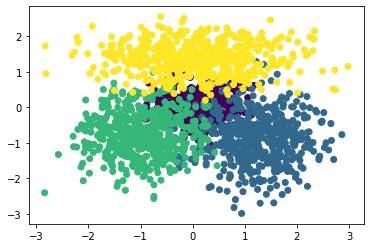

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline


data = Variable(torch.from_numpy(x), requires_grad=False)
model.train()
zs = model.get_z(data).data.numpy()

plt.scatter(zs[:,0], zs[:, 1], c=y)

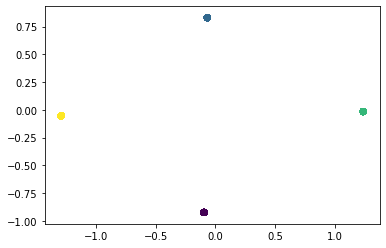

In [19]:
data = Variable(torch.from_numpy(x), requires_grad=False)
model.eval()
zs = model.get_z(data).data.numpy()

plt.scatter(zs[:,0], zs[:, 1], c=y)